# Import

In [1]:
import re
#import regex as re
import json
import pickle
import random
import datetime
import numpy as np
from scipy import spatial
import tensorflow as tf
from gensim.models.word2vec import Word2Vec

# Define functions

In [2]:
def sum_caption(caption):
    caption_splitted = re.split("[^a-zåàâäæçéèêëîïôöœßùûüÿA-ZÅÀÂÄÆÇÉÈÊËÎÏÔÖŒÙÛÜŸ’\-]+",caption)
    caption_vector = np.array(300*[0])
    for c in caption_splitted:
        try:
            caption_vector = caption_vector + w2v[c]
        except KeyError:
            pass
    return tuple(caption_vector)

# Load word2vec

In [3]:
w2v = Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
w2v.init_sims(replace=True)

# Load data

In [4]:
train_path = "mscoco/captions_val2014.json"
with open(train_path, 'r') as train_file:
    train_dict = json.load(train_file)
    
    print("Number of images: {}".format(len(train_dict["images"])))
    for inst in train_dict["images"][:3]:
        print(inst)
    print()
    
    print("Number of annotations: {}".format(len(train_dict["annotations"])))
    for inst in train_dict["annotations"][:3]:
        print(inst)

Number of images: 40504
{'license': 3, 'file_name': 'COCO_val2014_000000391895.jpg', 'coco_url': 'http://mscoco.org/images/391895', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}
{'license': 4, 'file_name': 'COCO_val2014_000000522418.jpg', 'coco_url': 'http://mscoco.org/images/522418', 'height': 480, 'width': 640, 'date_captured': '2013-11-14 11:38:44', 'flickr_url': 'http://farm1.staticflickr.com/1/127244861_ab0c0381e7_z.jpg', 'id': 522418}
{'license': 3, 'file_name': 'COCO_val2014_000000184613.jpg', 'coco_url': 'http://mscoco.org/images/184613', 'height': 336, 'width': 500, 'date_captured': '2013-11-14 12:36:29', 'flickr_url': 'http://farm3.staticflickr.com/2169/2118578392_1193aa04a0_z.jpg', 'id': 184613}

Number of annotations: 202654
{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}
{'image_id': 179765, 'id': 38, 'caption'

### Build new dictionary with pre-computed caption vectors

In [5]:
# Maybe have dict keys as strings
own_dict = {}
for im in train_dict["images"]:
    own_dict[im["id"]] = {}
    own_dict[im["id"]]["url"] = im["flickr_url"]
    own_dict[im["id"]]["file_name"] = im["file_name"]
for cap in train_dict["annotations"]:
    try:
        own_dict[cap["image_id"]]["captions"].append(cap["caption"])
        own_dict[cap["image_id"]]["vectors"].append(sum_caption(cap["caption"]))
    except KeyError:
        own_dict[cap["image_id"]]["captions"] = [cap["caption"]]
        own_dict[cap["image_id"]]["vectors"] = [sum_caption(cap["caption"])]

# Find most similar caption

In [6]:
query_image = random.choice(list(own_dict.keys()))
# Use all captions for query image
curr_best = {"im":-1, "dist":float("inf"),"query_cap_nr":-1, "match_cap_nr":-1}
for i in range(len(own_dict[query_image]["captions"])):
    query_vector = own_dict[query_image]["vectors"][i]
    for im in own_dict.items():
        if im[0] != query_image:
            for j in range(len(im[1]["captions"])):
                temp_vector = im[1]["vectors"][j]
                d = spatial.distance.cosine(query_vector,temp_vector)
                if d < curr_best["dist"]:
                    curr_best["dist"] = d
                    curr_best["im"] = im[0]
                    curr_best["query_cap_nr"] = i
                    curr_best["match_cap_nr"] = j

### Show images

Query image:
Several people are in a park flying kites.


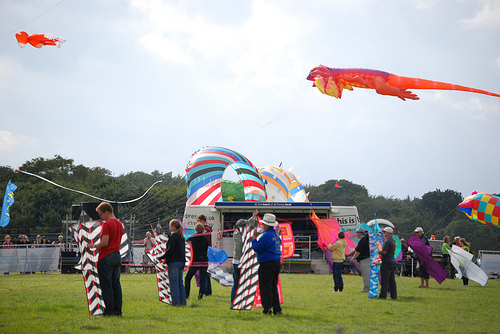

In [7]:
from IPython.display import Image
from IPython.core.display import HTML 

print("Query image:")
print(own_dict[query_image]["captions"][curr_best["query_cap_nr"]])
Image(own_dict[query_image]["url"])

Best match:
Many people are flying kites in a park.


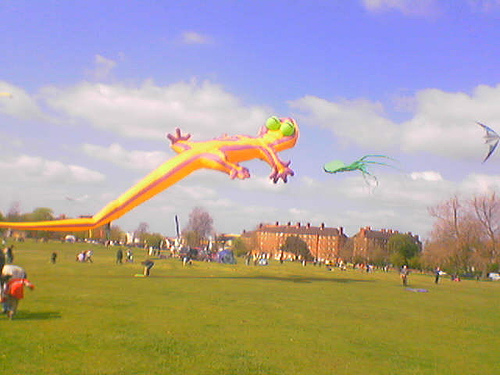

In [8]:
print("Best match:")
print(own_dict[curr_best["im"]]["captions"][curr_best["match_cap_nr"]])
Image(own_dict[curr_best["im"]]["url"])